In [1]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns',100)
pd.set_option('display.max_columns',100)
pd.set_option('expand_frame_repr',False)
#import calendar

In [2]:
# Reading the input file

import os
cwd = os.getcwd()
train = cwd + "\\Source\\train.csv"
train = pd.read_csv(train)

test = cwd + "\\Source\\test.csv"
test = pd.read_csv(test)

In [4]:
# print(train[train['Employment.Type'].notnull()]['loan_default'].value_counts() / len(train[train['Employment.Type'].notnull()]))
# print(train[train['Employment.Type'].isnull()]['loan_default'].value_counts() / len(train[train['Employment.Type'].isnull()]))
# print(train[train['Employment.Type']=='Self employed']['loan_default'].value_counts() / len(train[train['Employment.Type']=='Self employed']))
# print(train[train['Employment.Type']=='Salaried']['loan_default'].value_counts() / len(train[train['Employment.Type']=='Salaried']))

# # Though there are not much differences between the default distribution, it appears as if the Salaried people are more 
# # likely to pay loan in item when compared to Self Employed

In [3]:
# Converting the date formats

train['Date.of.Birth'] = pd.to_datetime(train['Date.of.Birth'], dayfirst=True)
train['DisbursalDate'] = pd.to_datetime(train['DisbursalDate'], dayfirst=True)

test['Date.of.Birth'] = pd.to_datetime(test['Date.of.Birth'], dayfirst=True)
test['DisbursalDate'] = pd.to_datetime(test['DisbursalDate'], dayfirst=True)

In [4]:
# Creating backup of the data

train_backup = train.copy()
test_backup = test.copy()

In [5]:
# # Restoring backup

# train = train_backup.copy()
# test = test_backup.copy()

In [6]:
# default = train[(train.loan_default==1) & (train['PERFORM_CNS.SCORE']<100)]
# no_default = train[(train.loan_default==0) & (train['PERFORM_CNS.SCORE']<100)]

#default.describe()
#print(no_default.describe)
#sample[(sample['PERFORM_CNS.SCORE']>600) & (sample['PERFORM_CNS.SCORE']<700)].head(20)

In [7]:
# Feature Engineering

# Creating the age of loan applicant at the time of disbursal
train['Age_when_applying'] = (train['DisbursalDate'] - train['Date.of.Birth']).dt.days / 365
test['Age_when_applying'] = (train['DisbursalDate'] - test['Date.of.Birth']).dt.days / 365
train['Age_when_applying'] = np.where(train['Age_when_applying'] < 0, 100+train['Age_when_applying'], train['Age_when_applying'])
test['Age_when_applying'] = np.where(test['Age_when_applying'] < 0, 100+test['Age_when_applying'], test['Age_when_applying'])

# Creating the avg acct age and cred hist age in months
train['avg_acct_age_mnth'] = ((train['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype('int64')*12) + train['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype('int64'))
train['avg_credit_hist_mnth'] = ((train['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype('int64')*12) + train['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype('int64'))

test['avg_acct_age_mnth'] = ((test['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype('int64')*12) + test['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype('int64'))
test['avg_credit_hist_mnth'] = ((test['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype('int64')*12) + test['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype('int64'))

# Creating a Overdue Percentage for Primary and Seconardy Accounts

train['prim_overdue_acct_pct'] = (train['PRI.OVERDUE.ACCTS'] / train['PRI.NO.OF.ACCTS']).fillna(0)
train['sec_overdue_acct_pct'] = (train['SEC.OVERDUE.ACCTS'] / train['SEC.NO.OF.ACCTS']).fillna(0)

test['prim_overdue_acct_pct'] = (test['PRI.OVERDUE.ACCTS'] / test['PRI.NO.OF.ACCTS']).fillna(0)
test['sec_overdue_acct_pct'] = (test['SEC.OVERDUE.ACCTS'] / test['SEC.NO.OF.ACCTS']).fillna(0)

# Creating loan to asset ratio
train['asset_to_loan_pct'] =  train['asset_cost'] / train['disbursed_amount']
test['asset_to_loan_pct'] =  test['asset_cost'] / test['disbursed_amount']

# Imputing zero values of CNS Score (Test data also imputed with train mean)
cred_score_value = np.quantile(train['PERFORM_CNS.SCORE'][train['PERFORM_CNS.SCORE'] > 100], 0.25)
train['credit_score'] = np.where(train['PERFORM_CNS.SCORE'] < 100, cred_score_value, train['PERFORM_CNS.SCORE'])
test['credit_score'] = np.where(test['PERFORM_CNS.SCORE'] < 100, cred_score_value, test['PERFORM_CNS.SCORE'])

# Credit History Desc
train['credit_score_desc'] = np.where(train.credit_score < 450, 'High Risk', 
                                             np.where(train.credit_score < 800, 'Medium Risk', 'Low Risk'))

test['credit_score_desc'] = np.where(test['credit_score'] < 450, 'High Risk',
                                              np.where(test['credit_score'] < 800, 'Medium Risk', 'Low Risk'))
train.loc[train.credit_score == 300, 'credit_score_desc'] = 'Medium Risk'
test.loc[test.credit_score == 300, 'credit_score_desc'] = 'Medium Risk'

# Creating a Total Outstanding balance
train['total_outstanding'] = train['disbursed_amount'] + train['PRI.CURRENT.BALANCE']
test['total_outstanding'] = test['disbursed_amount'] + test['PRI.CURRENT.BALANCE']

# Current to Outstanding ratio
train['curr_outstd_ratio'] = train['disbursed_amount'] / (train['disbursed_amount'] + train['PRI.CURRENT.BALANCE'])
test['curr_outstd_ratio'] = test['disbursed_amount'] / (test['disbursed_amount'] + test['PRI.CURRENT.BALANCE'])

# Previous Installment Capability
train['instalment_health'] = train['PRI.DISBURSED.AMOUNT'] / train['avg_credit_hist_mnth']
test['instalment_health'] = test['PRI.DISBURSED.AMOUNT'] / test['avg_credit_hist_mnth']


# Previous Installment to Current Disbursed Amt Ratio

train['inst_curr_disb_ratio'] = train['instalment_health'] / train['disbursed_amount']
test['inst_curr_disb_ratio'] = test['instalment_health'] / test['disbursed_amount']

# Filling missing values and inf values for Instalment Health and instalment to current disbursed ratio
train['instalment_health'].fillna(-9999, inplace=True)
test['instalment_health'].fillna(-9999, inplace=True)
train['inst_curr_disb_ratio'].fillna(-9.9, inplace=True)
test['inst_curr_disb_ratio'].fillna(-9.9, inplace=True)

train['instalment_health'] = np.where(np.isinf(train['instalment_health']),-999, train['instalment_health'])
test['instalment_health'] = np.where(np.isinf(test['instalment_health']),-999, test['instalment_health'])
train['inst_curr_disb_ratio'] = np.where(np.isinf(train['inst_curr_disb_ratio']),-0.9, train['inst_curr_disb_ratio'])
test['inst_curr_disb_ratio'] = np.where(np.isinf(test['inst_curr_disb_ratio']),-0.9, test['inst_curr_disb_ratio'])


# Impute Missing Employment Type with Unemployed
train['Employment.Type'] = np.where(train['Employment.Type'].isnull(), 'Unemployed', train['Employment.Type'])
test['Employment.Type'] = np.where(test['Employment.Type'].isnull(), 'Unemployed', test['Employment.Type'])


# Creating Age to Total Outstanding Ratio
train['age_outstd_ratio'] = train['Age_when_applying'] / train['total_outstanding']
test['age_outstd_ratio'] = test['Age_when_applying'] / test['total_outstanding']

In [8]:
# Creating additional features

# For State_ID

count = train.State_ID.value_counts().reset_index()
count.columns = ['State_ID', 'count']

default_count = train.State_ID[train.loan_default==1].value_counts().reset_index()
default_count.columns = ['State_ID', 'default_count']

df = pd.merge(count, default_count, how='left', on='State_ID')
df['def_pct_by_state'] = np.round(df.default_count / df['count'],2)
df['def_pct_by_state'].fillna(0, inplace=True)

train = pd.merge(train, df.iloc[:,[0,3]], how='left', on='State_ID')
test = pd.merge(test, df.iloc[:,[0,3]], how='left', on='State_ID')

# For supplier_id

count = train.supplier_id.value_counts().reset_index()
count.columns = ['supplier_id', 'count']

default_count = train.supplier_id[train.loan_default==1].value_counts().reset_index()
default_count.columns = ['supplier_id', 'default_count']

df = pd.merge(count, default_count, how='left', on='supplier_id')
df['def_pct_by_supplier'] = np.round(df.default_count / df['count'],2)
df['def_pct_by_supplier'].fillna(0, inplace=True)

train = pd.merge(train, df.iloc[:,[0,3]], how='left', on='supplier_id')
test = pd.merge(test, df.iloc[:,[0,3]], how='left', on='supplier_id')

# For branch_id

count = train.branch_id.value_counts().reset_index()
count.columns = ['branch_id', 'count']

default_count = train.branch_id[train.loan_default==1].value_counts().reset_index()
default_count.columns = ['branch_id', 'default_count']

df = pd.merge(count, default_count, how='left', on='branch_id')
df['def_pct_by_branch'] = np.round(df.default_count / df['count'],2)
df['def_pct_by_branch'].fillna(0, inplace=True)

train = pd.merge(train, df.iloc[:,[0,3]], how='left', on='branch_id')
test = pd.merge(test, df.iloc[:,[0,3]], how='left', on='branch_id')

# For manufacturer_id

count = train.manufacturer_id.value_counts().reset_index()
count.columns = ['manufacturer_id', 'count']

default_count = train.manufacturer_id[train.loan_default==1].value_counts().reset_index()
default_count.columns = ['manufacturer_id', 'default_count']

df = pd.merge(count, default_count, how='left', on='manufacturer_id')
df['def_pct_by_manufacturer'] = np.round(df.default_count / df['count'],2)
df['def_pct_by_manufacturer'].fillna(0, inplace=True)

train = pd.merge(train, df.iloc[:,[0,3]], how='left', on='manufacturer_id')
test = pd.merge(test, df.iloc[:,[0,3]], how='left', on='manufacturer_id')

# For Employee_code_ID

count = train.Employee_code_ID.value_counts().reset_index()
count.columns = ['Employee_code_ID', 'count']

default_count = train.Employee_code_ID[train.loan_default==1].value_counts().reset_index()
default_count.columns = ['Employee_code_ID', 'default_count']

df = pd.merge(count, default_count, how='left', on='Employee_code_ID')
df['def_pct_by_emp'] = np.round(df.default_count / df['count'],2)
df['def_pct_by_emp'].fillna(0, inplace=True)

train = pd.merge(train, df.iloc[:,[0,3]], how='left', on='Employee_code_ID')
test = pd.merge(test, df.iloc[:,[0,3]], how='left', on='Employee_code_ID')

# For Current_pincode_ID

count = train.Current_pincode_ID.value_counts().reset_index()
count.columns = ['Current_pincode_ID', 'count']

default_count = train.Current_pincode_ID[train.loan_default==1].value_counts().reset_index()
default_count.columns = ['Current_pincode_ID', 'default_count']

df = pd.merge(count, default_count, how='left', on='Current_pincode_ID')
df['def_pct_by_pin'] = np.round(df.default_count / df['count'],2)
df['def_pct_by_pin'].fillna(0, inplace=True)

train = pd.merge(train, df.iloc[:,[0,3]], how='left', on='Current_pincode_ID')
test = pd.merge(test, df.iloc[:,[0,3]], how='left', on='Current_pincode_ID')

test.fillna(test.mean(), inplace=True)

In [29]:
# Selecting columns for predictors:

predictors = ['disbursed_amount', 'asset_cost', 'ltv','MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT',
       'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'avg_acct_age_mnth', 'avg_credit_hist_mnth',
       'Age_when_applying', 'prim_overdue_acct_pct', 'sec_overdue_acct_pct', 'asset_to_loan_pct']

# Predictors for Random Forest Classifer after optimizing for Feature Importance
predictors = ['disbursed_amount', 'asset_cost', 'ltv','Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'credit_score',
              'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 
              'PRI.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 
              'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'avg_acct_age_mnth', 'avg_credit_hist_mnth', 
              'Age_when_applying', 'prim_overdue_acct_pct','asset_to_loan_pct', 'credit_score_desc', 'Employment.Type', 
              'inst_curr_disb_ratio', 'instalment_health', 'curr_outstd_ratio', 'total_outstanding', 'age_outstd_ratio',
             'def_pct_by_pin', 'def_pct_by_emp', 'def_pct_by_manufacturer', 'def_pct_by_state', 'def_pct_by_supplier', 
             'def_pct_by_branch']

# Predictors for Random Forest Classifer after 0.63 Score
predictors = ['disbursed_amount', 'asset_cost', 'ltv', 'credit_score',
              'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 
              'PRI.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 
              'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'avg_acct_age_mnth', 'avg_credit_hist_mnth', 
              'Age_when_applying', 'prim_overdue_acct_pct','asset_to_loan_pct', 
              'inst_curr_disb_ratio', 'instalment_health', 'curr_outstd_ratio', 'total_outstanding', 'age_outstd_ratio',
             'def_pct_by_pin', 'def_pct_by_emp', 'def_pct_by_manufacturer', 'def_pct_by_state', 'def_pct_by_supplier', 
             'def_pct_by_branch']

target = 'loan_default'
x = train[predictors]
y = train[target]
test_data = test[predictors]

In [30]:
# Creating Dummy Data

x = pd.get_dummies(x)
test_data = pd.get_dummies(test_data)

In [31]:
# # Standardizing the data to perform naive bayes

# from sklearn.preprocessing import QuantileTransformer

# transform_data = QuantileTransformer(output_distribution='normal')
# col_names = x.columns

# x = transform_data.fit_transform(x)
# x = pd.DataFrame(data=x, columns=col_names)

# test_data = transform_data.fit_transform(test_data)
# test_data = pd.DataFrame(data=test_data, columns=col_names)

# from sklearn.preprocessing import StandardScaler

# transform_data = StandardScaler()
# col_names = x.columns

# x = transform_data.fit_transform(x)
# x = pd.DataFrame(data=x, columns=col_names)

# test_data = transform_data.fit_transform(test_data)
# test_data = pd.DataFrame(data=test_data, columns=col_names)

In [ ]:
# colNames = x_train.columns

# from sklearn.decomposition import PCA

# pca = PCA(n_components=200)
# x_train = pca.fit_transform(x_train)
# pca_colNames = colNames[0:200]

# x_train = pd.DataFrame(data=x_train, columns=pca_colNames)

# np.sum(pca.explained_variance_ratio_)

# x_validation = pca.fit_transform(x_validation)
# x_validation = pd.DataFrame(data=x_validation, columns=pca_colNames)

In [32]:
# Train and Validation Split

from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(x,y, stratify=y, random_state=1, test_size=0.25)

In [33]:
# UNDER SAMPLING DATA
sampleData = x_train.copy()
sampleData['target'] = y_train

underSample_length = len(sampleData[sampleData.target == 1])

zero_target_indices = sampleData[sampleData.target == 0].index
random_indices = np.random.choice(zero_target_indices, underSample_length, replace=False)

target_data = sampleData[sampleData.target == 1]
zero_target_data = sampleData[sampleData.index.isin(random_indices)]
x_train = pd.concat([target_data, zero_target_data])

y_train = x_train['target']
x_train = x_train.drop('target', axis=1)

In [34]:
# # Running a Naive Bayes Model

# from sklearn.naive_bayes import GaussianNB
# model = GaussianNB()

# # Training the model

# model.fit(x_train, y_train)
# train_predictions = model.predict(x_train)
# predictions = model.predict(x_validation)

In [35]:
# # Converting to lgbm dataset

# import lightgbm as lgb

# x_train = lgb.Dataset(x_train, free_raw_data=False)
# x_validation = lgb.Dataset(x_validation, free_raw_data=False)

In [36]:
# # Running LGBM

# # Setting Parameters:

# param = {
#         'num_leaves': 4,
#         'objective': 'binary',
#         'metric': 'auc',
#         'early_stopping_rounds':10,
#        }

# num_round=10
# model = lgb.train(param, x_train, num_round, valid_sets=[x_validation])

In [37]:
# Running a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=10, min_samples_leaf=3, bootstrap=True, oob_score=True, n_jobs=-1, random_state=10)
# model = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=25, min_samples_leaf=5, oob_score=True, n_jobs=-1, random_state=10)

model = RandomForestClassifier(n_estimators=450, min_samples_split=10,min_samples_leaf=4, max_features=7, max_depth = 15, criterion='gini', bootstrap=False)
# Training the model

model.fit(x_train, y_train)
train_predictions = model.predict(x_train)
predictions = model.predict(x_validation)

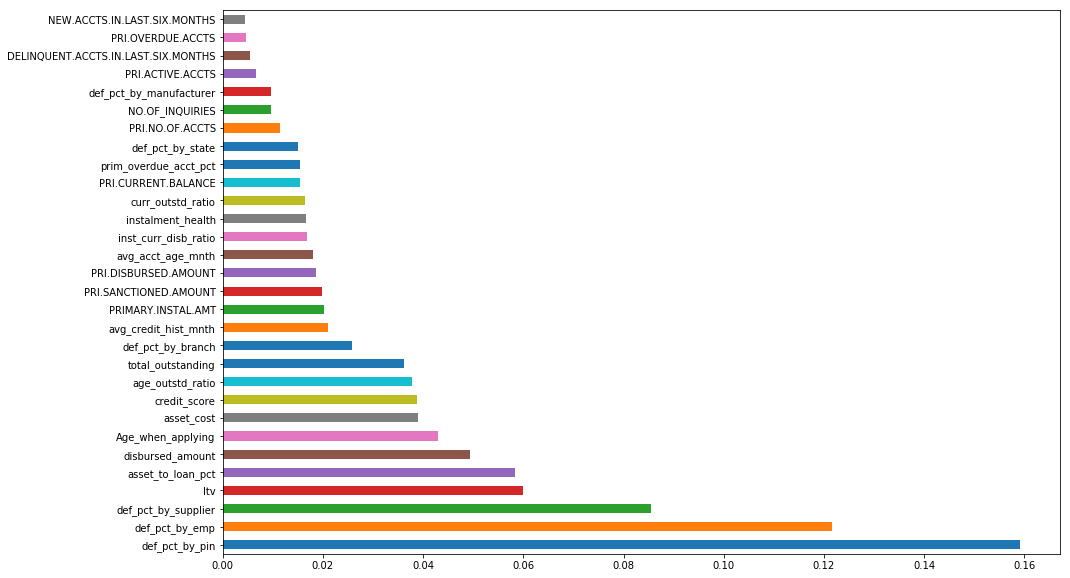

In [42]:
# Feature Importance Graph

plt.figure(figsize=(15,10))
feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feat_importances.nlargest(105).plot(kind='barh')

In [43]:
# Confusion Matrix and Report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Confusion Matrix Comparison
print("Confustion Matrix for Training Data")
print(confusion_matrix(y_train, train_predictions))
print("Confustion Matrix for Test Data")
print(confusion_matrix(y_validation, predictions))

# Classification Report Comparison
print("Classification Report for Training Data")
print(classification_report(y_train, train_predictions))
print("Classification Report for Test Data")
print(classification_report(y_validation, predictions))

Confustion Matrix for Training Data
[[30488  7470]
 [ 5410 32548]]
Confustion Matrix for Test Data
[[28624 17012]
 [ 4126  8527]]
Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     37958
           1       0.81      0.86      0.83     37958

   micro avg       0.83      0.83      0.83     75916
   macro avg       0.83      0.83      0.83     75916
weighted avg       0.83      0.83      0.83     75916

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.87      0.63      0.73     45636
           1       0.33      0.67      0.45     12653

   micro avg       0.64      0.64      0.64     58289
   macro avg       0.60      0.65      0.59     58289
weighted avg       0.76      0.64      0.67     58289



AUROC Plot: 0.7103


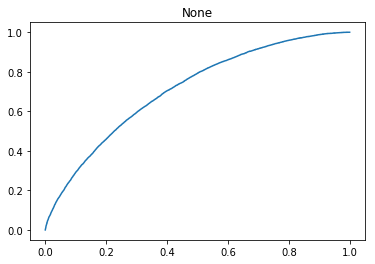

In [44]:
# AUC ROC CURVE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

predictions = model.predict_proba(x_validation)[:,1]
roc_auc_score(y_validation, predictions, average='weighted')

fpr, tpr, threshold = roc_curve(y_validation, predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("AUROC Plot:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

In [45]:
# Applying Model for Test Data

predictions = model.predict_proba(test_data)[:,1]
id_code = test['UniqueID']

output = pd.DataFrame({'UniqueID': id_code, 'loan_default':predictions})


In [46]:
output.to_csv(cwd + "\\Output\\Submission 9 - RF RANDOM SEARCH ALTERNATE 3 MODEL WITH LESS FEATURES 0.71 AUC.csv", index=False)

# RANDOM SEARCH OPTIMIZER

In [41]:
# # Creating a Random Grid

# from sklearn.model_selection import RandomizedSearchCV
# from pprint import pprint
# # model = (n_estimators=500, criterion='gini', max_depth=25, min_samples_leaf=5, oob_score=True, n_jobs=-1, random_state=10)

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start=50, stop=500, num=10)]

# # Number of features to consider at every split (For max_features we can also consider sqrt or auto)
# max_features = [int(x) for x in np.linspace(start= np.int(len(x_train.columns)/10),
#                                             stop= np.int(len(x_train.columns)/2), num=5)]
# # The split criterion
# criterion = ['gini', 'entropy']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'criterion': criterion,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# pprint(random_grid)

In [40]:
# # Performing the Random Search

# # Use the random grid to search for best hyperparameters
# # Let us use the base model "model" that is already created to tune the model against
# model = RandomForestClassifier()
# # Random search of parameters, using 5 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# model_random = RandomizedSearchCV(estimator = model, 
#                                   param_distributions = random_grid, 
#                                   n_iter = 20, cv = 3, verbose=250, random_state=42, n_jobs = -1)
# # Fit the random search model
# model_random.fit(x_train, y_train)

In [31]:
# Viewing the best parameters from the Random Search

# model_random.best_params_

# Below is the best parameter after tuning
# (n_estimators=300, min_samples_split=10,min_samples_leaf=2, max_features=11, max_depth = 15, criterion='entropy', bootstrap=True  )

# Below are alternative models with high score
# ALT MODEL 1
# (n_estimators=500, min_samples_split=5,min_samples_leaf=2, max_features=15, max_depth = 10, criterion='gini', bootstrap=True  )

# ALT MODEL 2
# (n_estimators=50, min_samples_split=10,min_samples_leaf=2, max_features=19, max_depth = 10, criterion='gini', bootstrap=True  )

# ALT MODEL 3
# (n_estimators=450, min_samples_split=10,min_samples_leaf=4, max_features=7, max_depth = 15, criterion='gini', bootstrap=False  )


In [39]:
# # Training the model

# model = RandomForestClassifier(n_estimators=450, min_samples_split=10,min_samples_leaf=4, max_features=7, max_depth = 15, criterion='gini', bootstrap=False, n_jobs=-1, random_state=10)

# # Training the model

# model.fit(x_train, y_train)
# train_predictions = model.predict(x_train)
# predictions = model.predict(x_validation)

# # Confusion Matrix and Report

# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report

# # Confusion Matrix Comparison
# print("Confustion Matrix for Training Data")
# print(confusion_matrix(y_train, train_predictions))
# print("Confustion Matrix for Test Data")
# print(confusion_matrix(y_validation, predictions))

# # Classification Report Comparison
# print("Classification Report for Training Data")
# print(classification_report(y_train, train_predictions))
# print("Classification Report for Test Data")
# print(classification_report(y_validation, predictions))

# # AUC ROC CURVE
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve

# predictions = model.predict_proba(x_validation)[:,1]
# roc_auc_score(y_validation, predictions, average='weighted')

# fpr, tpr, threshold = roc_curve(y_validation, predictions)

# # Calculating the AUC Score
# auc = np.trapz(tpr,fpr)
# print("AUROC Plot:", "%.4f" %auc)

In [38]:
# # Applying Model for Test Data

# predictions = model.predict_proba(test_data)[:,1]
# id_code = test['UniqueID']

# output = pd.DataFrame({'UniqueID': id_code, 'loan_default':predictions})
# output.to_csv(cwd + "\\Output\\Submission 8 - RF RANDOM SEARCH ALTERNATE 3 MODEL WITH ADDED FEATURES 0.7111 AUC.csv", index=False)

In [22]:
# # Import tools needed for visualization
# from sklearn.tree import export_graphviz
# import pydot

# # Pull out one tree from the forest
# tree = model.estimators_[5]

# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = x_train.columns, rounded = True, precision = 1)

# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')

# # Write graph to a png file
# graph.write_png('tree.png')

In [23]:
# Optimization Reference
# https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://www.mathworks.com/help/stats/tune-random-forest-using-quantile-error-and-bayesian-optimization.html
# https://www.kaggle.com/willkoehrsen/visualize-a-decision-tree-w-python-scikit-learn
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
# https://www.kaggle.com/residentmario/welcome-to-data-visualization
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0